In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input,  Activation
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, optimizers, layers
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action="ignore")

ImportError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import Libraries**

In [ ]:
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')

In [ ]:
#Reading train data

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
#Reading test data

test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
# Shape of the train set

train.shape

(159571, 8)

In [ ]:
# Describing train data

train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Getting the info about the train set

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
# Checking if there is any missing value

train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# **Preprocessing the comments of train dataset**

Data preprocessing includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:

*   Tokenizing the string : To tokenize means to split the strings into individual words without blanks or tabs.
*   Lowercasing : We will also convert each word in the string to lower case.
*   Removing stop words and punctuation : Stop words are words that don't add significant meaning to the text.
*   Stemming : Stemming is the process of converting a word to its most general form, or stem.

In [ ]:
# download the stopwords from NLTK
import nltk                                # Python library for NLP
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import regexp_tokenize   # module for tokenizing strings
from nltk.tokenize import TreebankWordTokenizer

# **Cleaning Train Dataset**

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
# Applying the clean_text on train set

train['comment_text'] = train['comment_text'].apply(lambda x: clean_text(x))

In [ ]:
train['comment_text'].head()

0    explanationwhy the edits made under my usernam...
1    daww he matches this background colour im seem...
2    hey man im really not trying to edit war its j...
3    morei cant make any real suggestions on improv...
4    you sir are my hero any chance you remember wh...
Name: comment_text, dtype: object

In [ ]:
# Reading test data

test['comment_text'].head()

0    Yo bitch Ja Rule is more succesful then you'll...
1    == From RfC == \n\n The title is fine as it is...
2    " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3    :If you have a look back at the source, the in...
4            I don't anonymously edit articles at all.
Name: comment_text, dtype: object

In [ ]:
# Applying the clean_text on test set

test['comment_text'] = test['comment_text'].apply(lambda x: clean_text(x))

In [ ]:
# After Applying the clean_text on test set

test['comment_text'].head()

0    yo bitch ja rule is more succesful then youll ...
1            from rfc   the title is fine as it is imo
2              sources    zawe ashton on lapland —    
3    if you have a look back at the source the info...
4              i dont anonymously edit articles at all
Name: comment_text, dtype: object

## **Data Visualization**

In [ ]:
# Checking the count of the various types of words

cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[cols].values

train_df = train['comment_text']
test_df = test['comment_text']

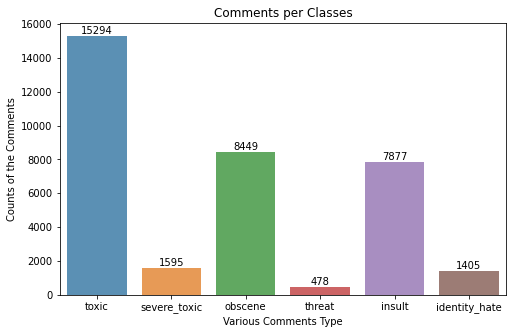

In [ ]:
val_counts = train[cols].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(val_counts.index, val_counts.values, alpha=0.8)

plt.title("Comments per Classes")
plt.xlabel("Various Comments Type")
plt.ylabel("Counts of the Comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")


plt.show()

## **Plotting Word Cloud**

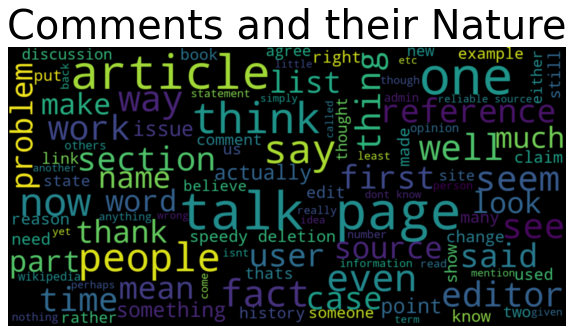

In [ ]:
# Word Cloud for train set

from wordcloud import WordCloud
words = ' '.join([text for text in train['comment_text'] ])


word_cloud = WordCloud(
                       width=1600,
                       height=800,
                       #colormap='PuRd',
                       margin=0,
                       max_words=500, # Maximum numbers of words we want to see
                       max_font_size=150, min_font_size=30,  # Font size range
                       background_color="black").generate(words)

plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title('Comments and their Nature', fontsize = 40)
plt.axis("off")
plt.show()

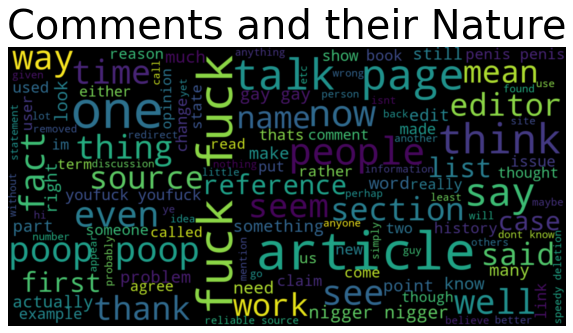

In [ ]:
# Word Cloud for test set

from wordcloud import WordCloud
words = ' '.join([text for text in test['comment_text'] ])


word_cloud = WordCloud(
                       width=1600,
                       height=800,
                       #colormap='PuRd',
                       margin=0,
                       max_words=500, # Maximum numbers of words we want to see
                       max_font_size=150, min_font_size=30,  # Font size range
                       background_color="black").generate(words)

plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title('Comments and their Nature', fontsize = 40)
plt.axis("off")
plt.show()

# **Tokenization**

In [ ]:
max_features = 22000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train_df))

tokenized_train = tokenizer.texts_to_sequences(train_df)
tokenized_test = tokenizer.texts_to_sequences(test_df)

In [ ]:
tokenized_train

# **Padding**

## Padding
This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long.

Sequences longer than num_timesteps are truncated so that they fit the desired length.

The position where padding or truncation happens is determined by the arguments padding and truncating, respectively. Pre-padding or removing values from the beginning of the sequence is the default.

In [ ]:
# Padding

maxlen = 200
X_train = pad_sequences(tokenized_train, maxlen = maxlen)
X_test = pad_sequences(tokenized_test, maxlen = maxlen)

In [ ]:
X_train.shape

(159571, 200)

# **Neural Model**
Turns positive integers (indexes) into dense vectors of fixed size.

Used LSTM Sequence Model(Long Short Term Memory) : are a special kind of RNN, capable of learning long-term dependencies.



In [ ]:
embed_size = 128
maxlen = 200
max_features = 22000

inp = Input(shape = (maxlen, ))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

# Building LSTM Model

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2816000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

## Training Model

In [ ]:
batch_size = 64
epochs = 2
model.fit(X_train, targets, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
2244/2244 [==============================] - 444s 190ms/step - loss: 0.1265 - accuracy: 0.8653 - val_loss: 0.0513 - val_accuracy: 0.9940
Epoch 2/2
2244/2244 [==============================] - 427s 190ms/step - loss: 0.0483 - accuracy: 0.9615 - val_loss: 0.0501 - val_accuracy: 0.9939


In [ ]:
model.save('model.h5')

## Prediction Model

In [ ]:
prediction = model.predict(X_test)
prediction

array([[9.95744348e-01, 3.51945698e-01, 9.38018680e-01, 6.09867871e-02,
        8.65221322e-01, 1.95000559e-01],
       [8.01444054e-04, 2.53431381e-06, 1.43706799e-04, 6.75197907e-06,
        1.00809004e-04, 1.81337964e-05],
       [2.56440043e-03, 2.41067773e-05, 5.98937273e-04, 4.96190551e-05,
        4.38868999e-04, 1.02900369e-04],
       ...,
       [3.37541103e-04, 5.85807243e-07, 6.19388156e-05, 1.63756852e-06,
        4.20365104e-05, 6.76616673e-06],
       [1.36906207e-02, 2.20947841e-05, 1.00502372e-03, 9.33294286e-05,
        1.85817480e-03, 2.66402960e-04],
       [9.84132886e-01, 4.89451587e-02, 7.18620002e-01, 1.21198297e-02,
        6.55442595e-01, 7.72957206e-02]], dtype=float32)

In [ ]:
prediction.shape

(153164, 6)

In [ ]:
prediction=pd.DataFrame(prediction)

In [ ]:
def threshold(text):
  for i in range(len(text)):
    if text[i]>=0.5:
      text[i]=1
    else:
      text[i]=0
  return text
prediction=prediction.apply(threshold)
prediction

,0,1,2,3,4,5
0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
153159,0.0,0.0,0.0,0.0,0.0,0.0
153160,0.0,0.0,0.0,0.0,0.0,0.0
153161,0.0,0.0,0.0,0.0,0.0,0.0
153162,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
classes =list(train.columns)
classes = classes[2:]
classes

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
def Classify(column):
    mp = {0 : "toxic", 1 : "severe_toxic", 2 : "obscene", 3 : "threat", 4 : "insult", 5 : "identity_hate"}
    c = 0
    l=[]
    for i in column:
      if(i == 1):
        l.append(mp[c])
      c+=1

    if(c % 6 == 0 and c != 0):
      if(l == []):
        return "None"
      return l
prediction=pd.DataFrame(prediction)
result = prediction.apply(Classify,axis=1)
prediction["Result"] = result
prediction

,0,1,2,3,4,5,Result
0,1.0,0.0,1.0,0.0,1.0,0.0,"[toxic, obscene, insult]"
1,0.0,0.0,0.0,0.0,0.0,0.0,None
2,0.0,0.0,0.0,0.0,0.0,0.0,None
3,0.0,0.0,0.0,0.0,0.0,0.0,None
4,0.0,0.0,0.0,0.0,0.0,0.0,None
...,...,...,...,...,...,...,...
153159,0.0,0.0,0.0,0.0,0.0,0.0,None
153160,0.0,0.0,0.0,0.0,0.0,0.0,None
153161,0.0,0.0,0.0,0.0,0.0,0.0,None
153162,0.0,0.0,0.0,0.0,0.0,0.0,None


In [ ]:
prediction['Comment_text'] = test['comment_text']
prediction

,0,1,2,3,4,5,Result,Comment_text
0,1.0,0.0,1.0,0.0,1.0,0.0,"[toxic, obscene, insult]",yo bitch ja rule is more succesful then youll ...
1,0.0,0.0,0.0,0.0,0.0,0.0,None,from rfc the title is fine as it is imo
2,0.0,0.0,0.0,0.0,0.0,0.0,None,sources zawe ashton on lapland —
3,0.0,0.0,0.0,0.0,0.0,0.0,None,if you have a look back at the source the info...
4,0.0,0.0,0.0,0.0,0.0,0.0,None,i dont anonymously edit articles at all
...,...,...,...,...,...,...,...,...
153159,0.0,0.0,0.0,0.0,0.0,0.0,None,i totally agree this stuff is nothing but to...
153160,0.0,0.0,0.0,0.0,0.0,0.0,None,throw from out field to home plate does it ...
153161,0.0,0.0,0.0,0.0,0.0,0.0,None,okinotorishima categories i see your chan...
153162,0.0,0.0,0.0,0.0,0.0,0.0,None,one of the founding nations of the eu germ...


In [ ]:
prediction.drop(0,axis=1,inplace=True)
prediction.drop(1,axis=1,inplace=True)
prediction.drop(2,axis=1,inplace=True)
prediction.drop(3,axis=1,inplace=True)
prediction.drop(4,axis=1,inplace=True)
prediction.drop(5,axis=1,inplace=True)
prediction

,Result,Comment_text
0,"[toxic, obscene, insult]",yo bitch ja rule is more succesful then youll ...
1,None,from rfc the title is fine as it is imo
2,None,sources zawe ashton on lapland —
3,None,if you have a look back at the source the info...
4,None,i dont anonymously edit articles at all
...,...,...
153159,None,i totally agree this stuff is nothing but to...
153160,None,throw from out field to home plate does it ...
153161,None,okinotorishima categories i see your chan...
153162,None,one of the founding nations of the eu germ...


In [ ]:
output = pd.DataFrame(prediction, columns = ['Comment_text', 'Result'])

In [ ]:
output

,Comment_text,Result
0,yo bitch ja rule is more succesful then youll ...,"[toxic, obscene, insult]"
1,from rfc the title is fine as it is imo,None
2,sources zawe ashton on lapland —,None
3,if you have a look back at the source the info...,None
4,i dont anonymously edit articles at all,None
...,...,...
153159,i totally agree this stuff is nothing but to...,None
153160,throw from out field to home plate does it ...,None
153161,okinotorishima categories i see your chan...,None
153162,one of the founding nations of the eu germ...,None
